# Multitask GP Regression using pymc with GP LatentKron
Data Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [54]:
import numpy as np
import pymc as pm
from pymc.gp.cov import Covariance
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [55]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up training data: same X, three Y outputs

In [56]:
N = 15
train_x = np.linspace(0, 1, N)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [57]:
train_x.shape, train_y.shape

((15,), (15, 3))

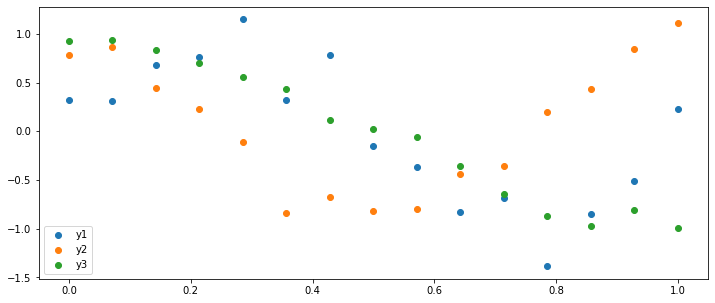

In [58]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [59]:
train_x.shape, train_y.shape

((15,), (15, 3))

In [60]:
x = train_x.reshape(-1,1)
y = train_y.reshape(-1,1)
x.shape, y.shape

((15, 1), (45, 1))

In [61]:
task_i = np.linspace(0, 2, 3)[:, None]
Xs = [x, task_i] # For training
Xs[0].shape, Xs[1].shape, x.shape

((15, 1), (3, 1), (15, 1))

In [62]:
M = 20
xnew = np.linspace(-0.5, 1.5, M)
Xnew = pm.math.cartesian(xnew, task_i) # For prediction
Xnew.shape

(60, 2)

### Option 1: Implement ICM (one kernel) by using LatentKron with Coregion kernel

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

#### Create a model

In [63]:
Xs[0].shape, Xs[1]

((15, 1),
 array([[0.],
        [1.],
        [2.]]))

In [64]:
# y = (K + noise) * α = (L x L.T) * α = y
# B = L * α
# L.T * B = y
# B = solve(y, L) = (L\y)
# α = solve(B, L.T) = (B\L.T) = L\(L\y)

In [65]:
with pm.Model() as model:
    # Kernel: K_1(x,x')
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    # Coregion B matrix: K_2(o,o')
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)
    
    # Specify the GP.  The default mean function is `Zero`.
    mogp = pm.gp.LatentKron(cov_funcs=[cov, coreg])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    # Place a GP prior over thXse function f.
    f = mogp.prior("f", Xs=Xs)
    y_ = pm.Normal("y_", mu=f, sigma=sigma, observed=y.squeeze())    

In [66]:
coreg.full(task_i).eval()

array([[10.28904453,  0.14694275, -6.55754881],
       [ 0.14694275, 21.91901365, 23.71757524],
       [-6.55754881, 23.71757524, 33.85870399]])

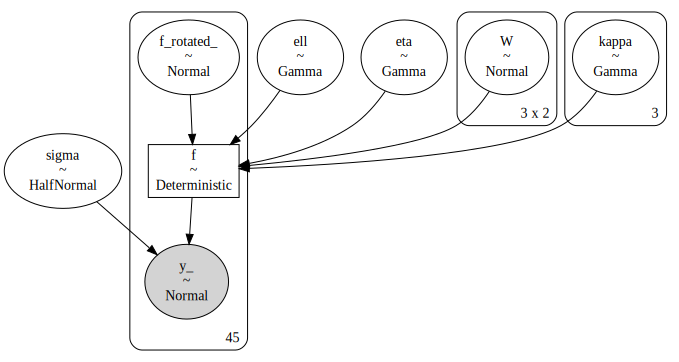

In [67]:
pm.model_to_graphviz(model)

In [68]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma, f_rotated_]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 118 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 4min 56s, sys: 10min 40s, total: 15min 36s
Wall time: 2min 3s


#### Prediction

In [69]:
%%time
with model:
    preds = mogp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 4.28 s, sys: 4.03 s, total: 8.32 s
Wall time: 3 s


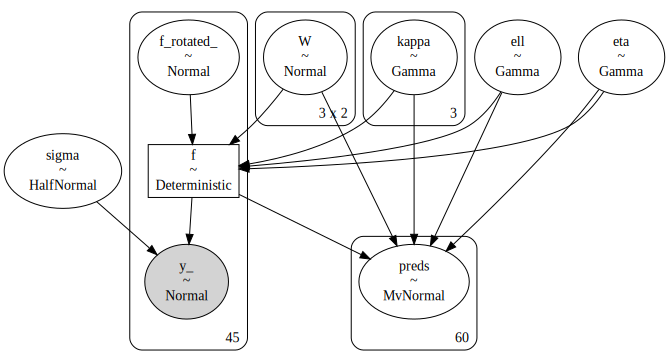

In [70]:
pm.model_to_graphviz(model)

In [71]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 60)

#### Plot the first GP

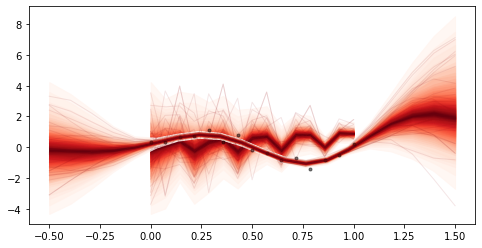

In [72]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 0:N], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 0], xnew)
plt.show()

#### Plot the second GP

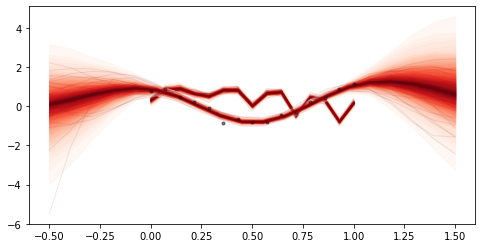

In [73]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, N:2*N], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 1], xnew)
plt.show()

### Option 2.1: Implement ICM (one kernel) by using pm.gp.cov.Kron with pm.gp.Marginal

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

In [74]:
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((15, 1), (3, 1), (45, 2))

In [75]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)    
    
    cov_func = pm.gp.cov.Kron([cov, coreg])    
    sigma = pm.HalfNormal("sigma", sigma=3)    
    gp = pm.gp.Marginal(cov_func=cov_func)    
    y_ = gp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [76]:
cov(x).eval().shape, coreg(task_i).eval().shape, cov_func(X).eval().shape

((15, 15), (3, 3), (45, 45))

In [77]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 21 seconds.


CPU times: user 57.9 s, sys: 1min 55s, total: 2min 53s
Wall time: 25.8 s


#### Prediction

In [78]:
%%time
with model:
    preds = gp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 3.21 s, sys: 3.65 s, total: 6.87 s
Wall time: 1.88 s


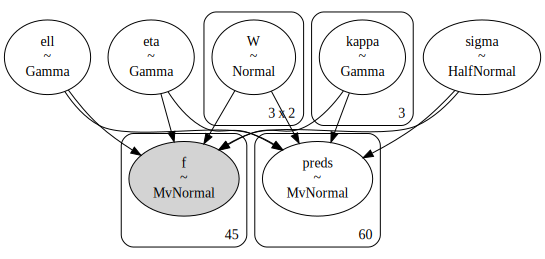

In [79]:
pm.model_to_graphviz(model)

In [80]:
Xnew.shape

(60, 2)

In [81]:
Marginalf_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 60)

#### Plot the GP prediction

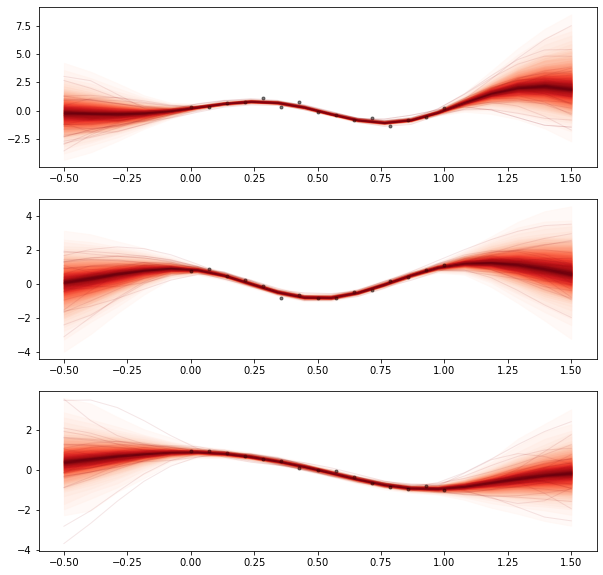

In [82]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [83]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",0.008,2.577,-5.126,4.272,0.154,0.109,281.0,479.0,NaN
"W[0, 1]",-0.198,2.741,-5.495,4.618,0.152,0.107,330.0,367.0,NaN
"W[1, 0]",-0.091,1.989,-3.679,3.626,0.129,0.091,239.0,292.0,NaN
"W[1, 1]",0.142,2.139,-3.744,4.243,0.113,0.088,360.0,330.0,NaN
"W[2, 0]",0.073,1.305,-2.331,2.469,0.066,0.052,404.0,289.0,NaN
"W[2, 1]",-0.059,1.229,-2.469,2.098,0.067,0.055,337.0,326.0,NaN
ell,0.372,0.075,0.237,0.509,0.003,0.002,464.0,318.0,NaN
eta,0.712,0.310,0.250,1.315,0.014,0.010,469.0,415.0,NaN
kappa[0],1.794,1.341,0.043,4.087,0.065,0.046,364.0,369.0,NaN
kappa[1],1.723,1.224,0.054,3.907,0.060,0.044,344.0,197.0,NaN


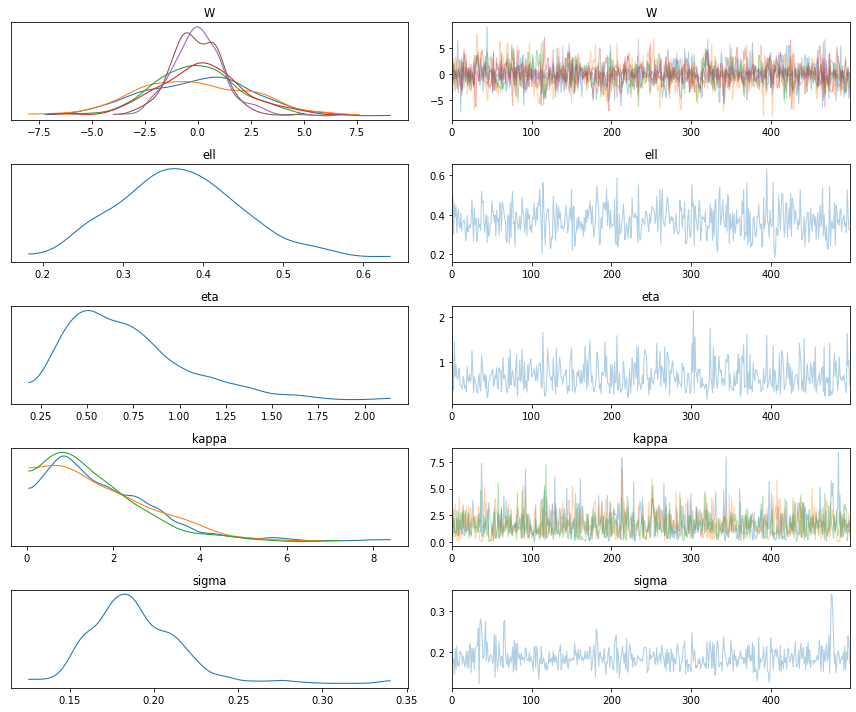

In [84]:
az.plot_trace(gp_trace);
plt.tight_layout()

### Option 2.2: Implement LCM by using pm.gp.cov.Kron with pm.gp.Marginal

$$
K = ( K_{11}(x, x') + K_{12}(x, x') ) \otimes K_2(o, o')
$$

In [85]:
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((15, 1), (3, 1), (45, 2))

In [86]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    ell2 = pm.Gamma("ell2", alpha=2, beta=0.5)
    eta2 = pm.Gamma("eta2", alpha=3, beta=1)
    cov2 = eta2**2 * pm.gp.cov.Matern32(1, ls=ell2)
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)    
    
    cov_func = pm.gp.cov.Kron([cov+cov2, coreg])    
    sigma = pm.HalfNormal("sigma", sigma=3)    
    gp = pm.gp.Marginal(cov_func=cov_func)    
    y_ = gp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [87]:
cov(x).eval().shape, coreg(task_i).eval().shape, cov_func(X).eval().shape

((15, 15), (3, 3), (45, 45))

In [88]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, ell2, eta2, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 30 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5499, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: user 1min 20s, sys: 2min 39s, total: 4min
Wall time: 35.9 s


#### Prediction

In [89]:
%%time
with model:
    preds = gp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 4 s, sys: 4.36 s, total: 8.36 s
Wall time: 2.67 s


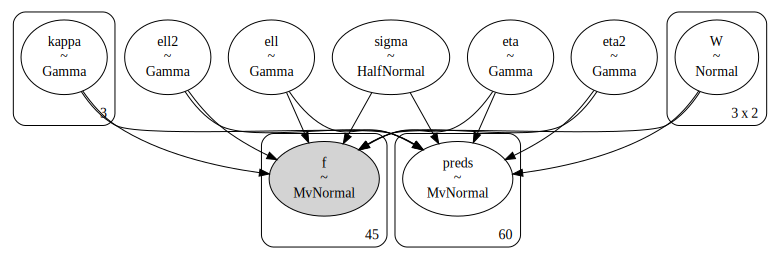

In [90]:
pm.model_to_graphviz(model)

In [91]:
Xnew.shape

(60, 2)

In [92]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 60)

#### Plot the GP prediction

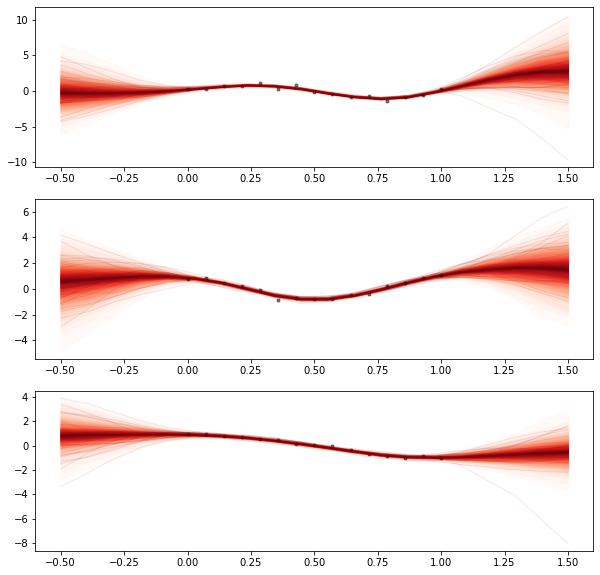

In [93]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [94]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",-0.053,2.800,-4.911,5.121,0.328,0.233,78.0,332.0,NaN
"W[0, 1]",-0.259,2.685,-4.919,4.533,0.256,0.181,112.0,207.0,NaN
"W[1, 0]",0.045,1.807,-3.013,3.630,0.152,0.110,141.0,186.0,NaN
"W[1, 1]",-0.019,1.785,-4.147,2.846,0.134,0.095,165.0,312.0,NaN
"W[2, 0]",-0.067,1.134,-2.052,2.010,0.118,0.100,106.0,60.0,NaN
"W[2, 1]",-0.154,0.995,-1.957,1.714,0.089,0.063,128.0,155.0,NaN
ell,1.788,2.454,0.253,7.317,0.387,0.276,33.0,158.0,NaN
eta,1.222,0.734,0.236,2.614,0.069,0.049,125.0,254.0,NaN
ell2,3.541,2.288,0.519,7.650,0.341,0.243,41.0,193.0,NaN
eta2,1.280,0.816,0.169,2.824,0.104,0.074,49.0,48.0,NaN


In [95]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu Sep 15 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

pymc      : 4.1.7
matplotlib: 3.5.2
arviz     : 0.12.1
numpy     : 1.22.4

Watermark: 2.3.0

